In [1]:
import collections
import os
import shutil
import tqdm

import numpy as np
import PIL.Image
import torch
import torchvision

# check your pytorch version

In [4]:
torch.__version__               # PyTorch version
torch.version.cuda              # Corresponding CUDA version
torch.backends.cudnn.version()  # Corresponding cuDNN version
torch.cuda.get_device_name(0)   # GPU type

'Quadro M5000'

# fixed random seed of torch

In [19]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [20]:
##在命令行指定环境变量
#CUDA_VISIBLE_DEVICES=0,1 python train.py#
#或在代码中指定#
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
##判断是否有 CUDA 支持
torch.cuda.is_available()


True

In [15]:
#设置为 cuDNN benchmark 模
#Benchmark 模式会提升计算速度，但是由于计算中有随机性，每次网络前馈结果略有差异
torch.backends.cudnn.benchmark = True
#如果想要避免这种结果波动，设置
torch.backends.cudnn.deterministic = True

# clear gpu buffer

In [17]:
#有时 Control-C 中止运行后 GPU 存储没有及时释放，需要手动清空。在 PyTorch 内部可以
torch.cuda.empty_cache()
#或在命令行可以先使用 ps 找到程序的 PID，再使用 kill 结束该进程
#ps aux | grep pythonkill -9 [pid]
#或者直接重置没有被清空的 GPU
#nvidia-smi --gpu-reset -i [gpu_id]

# deal with tensor

## tensor info

In [23]:
tensor = torch.rand(1,100)
print(tensor.type())   # Data type
print(tensor.size())   # Shape of the tensor. It is a subclass of Python tuple
print(tensor.dim())    # Number of dimensions.

torch.FloatTensor
torch.Size([1, 100])
2


## data convert

In [24]:
# Set default tensor type. Float in PyTorch is much faster than double.
torch.set_default_tensor_type(torch.FloatTensor)

# Type convertions.
tensor = tensor.cuda()
tensor = tensor.cpu()
tensor = tensor.float()
tensor = tensor.long()

## torch.tensor     with     np.ndarray

In [25]:
# torch.Tensor -> np.ndarray.
ndarray = tensor.cpu().numpy()

# np.ndarray -> torch.Tensor.
tensor = torch.from_numpy(ndarray).float()
tensor = torch.from_numpy(ndarray.copy()).float()  # If ndarray has negative stride

## torch.Tensor     with     PIL.Image

In [62]:
# PyTorch 中的张量默认采用 N×D×H×W 的顺序，并且数据范围在 [0, 1]，需要进行转置和规范化。
tensor = torch.randn(3,28,28)
# torch.Tensor -> PIL.Image
image = PIL.Image.fromarray(torch.clamp(tensor * 255, min=0, max=255).byte().permute(1, 2, 0).cpu().numpy())
image = torchvision.transforms.functional.to_pil_image(tensor)  # Equivalently way

# PIL.Image -> torch.Tensor.
path = "IMG/DDPG_VOICE.jpeg"
tensor = torch.from_numpy(np.asarray(PIL.Image.open(path)))
print(tensor.dim)
tensor.permute(2, 0, 1).float() / 255
tensor = torchvision.transforms.functional.to_tensor(PIL.Image.open(path))  # Equivalently way

<built-in method dim of Tensor object at 0x000001AFBF998B40>


## np.ndarray 与 PIL.Image 转换

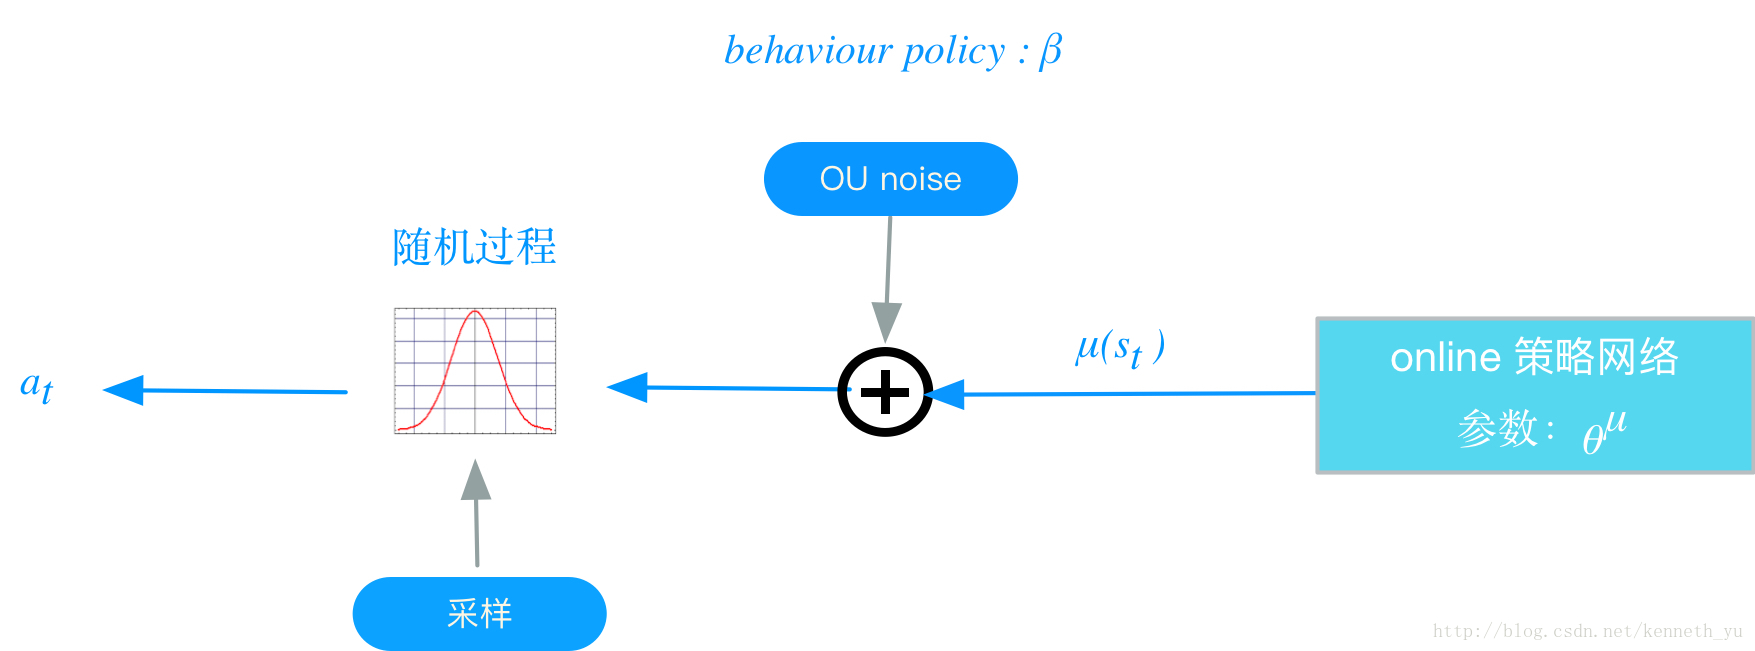

In [65]:
# PIL.Image -> np.ndarray.
ndarray = np.asarray(PIL.Image.open(path))
# np.ndarray -> PIL.Image.
image = PIL.Image.fromarray(ndarray.astype(np.uint8))
image

In [71]:
#从只包含一个元素的张量中提取值
#这在训练时统计 loss 的变化过程中特别有用。否则这将累积计算图，使 GPU 存储占用量越来越大。
tensor = torch.randn(1,1).cuda()
value = tensor.item()
value

-0.4847152829170227

# Tensor reshape

In [75]:
# 张量形变常常需要用于将卷积层特征输入全连接层的情形。相比 torch.view，torch.reshape 可以自动处理输入张量不连续的情况。
tensor = torch.randn(3,224*224)
tensor = torch.reshape(tensor, shape=(3,224,224))
print(tensor.dim)
# 打乱顺序
tensor = tensor[torch.randperm(tensor.size(0))]  # Shuffle the first dimension
print(tensor.dim)
# 水平翻转
# PyTorch 不支持 tensor[::-1] 这样的负步长操作，水平翻转可以用张量索引实现。
# Assume tensor has shape N*D*H*W.
# tensor = tensor[:, :, :, torch.arange(tensor.size(3) - 1, -1, -1).long()]

<built-in method dim of Tensor object at 0x000001AFBFA00BD0>
<built-in method dim of Tensor object at 0x000001AFBF55BB88>


# clone Tensor

In [78]:
# 有三种复制的方式，对应不同的需求。
# Operation                 |  New/Shared memory | Still in computation graph |
tensor.clone()            # |        New         |          Yes               |
tensor.detach()           # |      Shared        |          No                |
tensor.detach().clone().dim   # |        New         |          No                |

<function Tensor.dim>

# concat Tensor

In [81]:
# 注意 torch.cat 和 torch.stack 的区别在于 torch.cat 沿着给定的维度拼接，
# 而 torch.stack 会新增一维。例如当参数是 3 个 10×5 的张量，
# torch.cat 的结果是 30×5 的张量，而 torch.stack 的结果是 3×10×5 的张量。
list_of_tensors = (tensor, tensor)
tensor = torch.cat(list_of_tensors, dim=0)
tensor = torch.stack(list_of_tensors, dim=0)

# Get zero or non-zero

In [82]:
torch.nonzero(tensor)               # Index of non-zero elements
torch.nonzero(tensor == 0)          # Index of zero elements
torch.nonzero(tensor).size(0)       # Number of non-zero elements
torch.nonzero(tensor == 0).size(0)  # Number of zero elements

0

# expand tensor

In [84]:
# Expand tensor of shape 64*512 to shape 64*512*7*7.
tensor = torch.randn(64, 512)
torch.reshape(tensor, (64, 512, 1, 1)).expand(64, 512, 7, 7).shape

torch.Size([64, 512, 7, 7])

# Matrix multiplication

In [87]:
# Matrix multiplication: (m*n) * (n*p) -> (m*p).
tensor1 = tensor2 = torch.randn(28,28)
result = torch.mm(tensor1, tensor2)
tensor1 = tensor2 = torch.randn(32, 28,28)
# Batch matrix multiplication: (b*m*n) * (b*n*p) -> (b*m*p).
result = torch.bmm(tensor1, tensor2)
tensor1 = tensor2 = torch.randn(28,28)
# Element-wise multiplication.
result = tensor1 * tensor2

# calculate distance

In [91]:
#计算两组数据之间的两两欧式距离
# X1 is of shape m*d.
X1 = torch.randn(1,2)
X2 = torch.randn(1,2)
m = n = d = 2
X1 = torch.unsqueeze(X1, dim=1).expand(m, n, d)
# X2 is of shape n*d.
X2 = torch.unsqueeze(X2, dim=0).expand(m, n, d)
# dist is of shape m*n, where dist[i][j] = sqrt(|X1[i, :] - X[j, :]|^2)
dist = torch.sqrt(torch.sum((X1 - X2) ** 2, dim=2))

# Convolution Layer
nomal convolution configure

if convolution layer too complex，you can use this [visualizer tool](https://ezyang.github.io/convolution-visualizer/index.html):
https://ezyang.github.io/convolution-visualizer/index.html

In [94]:
in_channels = 3
out_channels = 24
conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=True)

# Global Average Pooling layer

In [95]:
gap = torch.nn.AdaptiveAvgPool2d(output_size=1)

# Bilinear pooling

In [101]:
N = D = H = W = 2
X = torch.randn(N*D*H*W)
X = torch.reshape(X,(N, D, H * W))                        # Assume X has shape N*D*H*W
# print(X)
X = torch.bmm(X, torch.transpose(X, 1, 2)) / (H * W)  # Bilinear pooling
# print(X)
assert X.size() == (N, D, D)
X = torch.reshape(X, (N, D * D))
X = torch.sign(X) * torch.sqrt(torch.abs(X) + 1e-5)   # Signed-sqrt normalization
X = torch.nn.functional.normalize(X)                  # L2 normalization
print(X)

tensor([[0.4173, 0.4503, 0.4503, 0.6484],
        [0.6188, 0.4781, 0.4781, 0.4000]])


# Multi-GPU Synchronize BN(Batch normalization)
when we use (torch.nn.DataParallel) to place code in multi GPU
BN layer of Pytorch default independently calculate mean and Standard Deviation in each GPU.

Synchronize BN use data of all GPU to calculate the mean and Standard Deviation of BN layer.

Benefit: relieve pressure that GPU inaccurately calculate when the batch size is small.

more detail you can visit [here](https://github.com/vacancy/Synchronized-BatchNorm-PyTorch)


## （BN） Moving average

In [118]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.register_buffer('running_mean', torch.zeros(10))

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #self.running_mean += momentum * (current - self.running_mean)
        return F.log_softmax(x, dim=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Net().to(device)

## calculate the number of Model paramater
error code:

~~num_parameters = sum(torch.numel(parameter) for parameter in model.parameters())~~

maybe you can test [this](https://github.com/sksq96/pytorch-summary):
```shell
pip install torchsummary
```

In [119]:
from torchsummary import summary
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


## model parameter initialization
notice that the different of model.modules() and model.children():
model.modules(): will iterate all layer
model.children(): just iterate next layer

In [120]:
# Common practise for initialization.
for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out',
                                      nonlinearity='relu')
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias, val=0.0)
    elif isinstance(layer, torch.nn.BatchNorm2d):
        torch.nn.init.constant_(layer.weight, val=1.0)
        torch.nn.init.constant_(layer.bias, val=0.0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias, val=0.0)

# Initialization with given tensor.
layer.weight = torch.nn.Parameter(tensor)

## part layer of model using pre-train model:
if your model is saved by (torch.nn.DataParallel) so that it need:

In [ ]:
model.load_state_dict(torch.load('model,pth'), strict=False)

# Get the video info

In [3]:
import cv2
mp4_path = "C:/Users/VCC/Videos/VR.mp4"
video = cv2.VideoCapture(mp4_path)
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video.get(cv2.CAP_PROP_FPS))
video.release()
print(video,height,width,num_frames,fps)

<VideoCapture 000002372EB6C390> 730 1034 1507 20


# TSN from each Segment sampling one fps video

In [5]:
K = 6
if is_train:
    if num_frames > K:
        # Random index for each segment.
        frame_indices = torch.randint(
            high=num_frames // K, size=(K,), dtype=torch.long)
        frame_indices += num_frames // K * torch.arange(K)
    else:
        frame_indices = torch.randint(
            high=num_frames, size=(K - num_frames,), dtype=torch.long)
        frame_indices = torch.sort(torch.cat((
            torch.arange(num_frames), frame_indices)))[0]
else:
    if num_frames > K:
        # Middle index for each segment.
        frame_indices = num_frames / K // 2
        frame_indices += num_frames // K * torch.arange(K)
    else:
        frame_indices = torch.sort(torch.cat((                              
            torch.arange(num_frames), torch.arange(K - num_frames))))[0]
assert frame_indices.size() == (K,)
return [frame_indices[i] for i in range(K)]

NameError: name 'is_train' is not defined

# Extract ImageNet Pre-train mmodel layer feature

In [5]:
# VGG-16 relu5-3 feature.
model = torchvision.models.vgg16(pretrained=True).features[:-1]
# VGG-16 pool5 feature.
model = torchvision.models.vgg16(pretrained=True).features
# VGG-16 fc7 feature.
model = torchvision.models.vgg16(pretrained=True)
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-3])
# ResNet GAP feature.
model = torchvision.models.resnet18(pretrained=True)
model = torch.nn.Sequential(collections.OrderedDict(
    list(model.named_children())[:-1]))
image = torch.randn(32,3,28,28)
with torch.no_grad():
    model.eval()
    conv_representation = model(image)

In [6]:
class FeatureExtractor(torch.nn.Module):
    """Helper class to extract several convolution features from the given
    pre-trained model.

    Attributes:
        _model, torch.nn.Module.
        _layers_to_extract, list<str> or set<str>

    Example:
        >>> model = torchvision.models.resnet152(pretrained=True)
        >>> model = torch.nn.Sequential(collections.OrderedDict(
                list(model.named_children())[:-1]))
        >>> conv_representation = FeatureExtractor(
                pretrained_model=model,
                layers_to_extract={'layer1', 'layer2', 'layer3', 'layer4'})(image)
    """
    def __init__(self, pretrained_model, layers_to_extract):
        torch.nn.Module.__init__(self)
        self._model = pretrained_model
        self._model.eval()
        self._layers_to_extract = set(layers_to_extract)

    def forward(self, x):
        with torch.no_grad():
            conv_representation = []
            for name, layer in self._model.named_children():
                x = layer(x)
                if name in self._layers_to_extract:
                    conv_representation.append(x)
            return conv_representation

# Fine Tuning  Full Connect layer

In [8]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(512, 100)  # Replace the last fc layer
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

Fine tuning full connect layer by big learning rate

Fine tuning convolution layer by little learning rate

In [9]:
model = torchvision.models.resnet18(pretrained=True)
finetuned_parameters = list(map(id, model.fc.parameters()))
conv_parameters = (p for p in model.parameters() if id(p) not in finetuned_parameters)
parameters = [{'params': conv_parameters, 'lr': 1e-3}, 
              {'params': model.fc.parameters()}]
optimizer = torch.optim.SGD(parameters, lr=1e-2, momentum=0.9, weight_decay=1e-4)

# Model training
in here ToTensor will operate PIL.Image or shape H×W×D,range in [0, 255]

np.ndarray convert to shape D×H×W，range torch.Tensor in [0.0, 1.0]

In [11]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=224,
                                             scale=(0.08, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225)),
 ])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225)),
])

# train code framework

In [12]:
def tarin():
    for t in epoch(80):
        for images, labels in tqdm.tqdm(train_loader, desc='Epoch %3d' % (t + 1)):
            images, labels = images.cuda(), labels.cuda()
            scores = model(images)
            loss = loss_function(scores, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# label smoothing

In [13]:
def tarin():
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        N = labels.size(0)
        # C is the number of classes.
        smoothed_labels = torch.full(size=(N, C), fill_value=0.1 / (C - 1)).cuda()
        smoothed_labels.scatter_(dim=1, index=torch.unsqueeze(labels, dim=1), value=0.9)

        score = model(images)
        log_prob = torch.nn.functional.log_softmax(score, dim=1)
        loss = -torch.sum(log_prob * smoothed_labels) / N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Mixup

In [16]:
def train():
    alpha = 2
    beta_distribution = torch.distributions.beta.Beta(alpha, alpha)
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        # Mixup images.
        lambda_ = beta_distribution.sample([]).item()
        index = torch.randperm(images.size(0)).cuda()
        mixed_images = lambda_ * images + (1 - lambda_) * images[index, :]

        # Mixup loss.    
        scores = model(mixed_images)
        loss = (lambda_ * loss_function(scores, labels) 
                + (1 - lambda_) * loss_function(scores, labels[index]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# L1 Normalization

In [21]:
l1_regularization = torch.nn.L1Loss(reduction='sum')
loss = torch.randn(1,1)  # Standard cross-entropy loss
for param in model.parameters():
    loss += torch.sum(torch.abs(param))
loss.backward()

# L2 Normalization / weight decay

In [23]:
bias_list = (param for name, param in model.named_parameters() if name[-4:] == 'bias')
others_list = (param for name, param in model.named_parameters() if name[-4:] != 'bias')
parameters = [{'parameters': bias_list, 'weight_decay': 0},                
              {'parameters': others_list}]
# optimizer = torch.optim.SGD(parameters, lr=1e-2, momentum=0.9, weight_decay=1e-4)

# gradient Clipping

In [29]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20)

19.999998952784427

# calculate SoftMax output accurate

In [56]:
model = torchvision.models.resnet18(pretrained=True)
images = torch.randn(32,3,28,28)
labels = torch.randn(1,32)*10
labels = labels.long()
score = model(images)
prediction = torch.argmax(score, dim=1)
num_correct = torch.sum(prediction == labels).item()
accuruacy = num_correct / labels.size(0)

# Visualization tools

# [pytorchviz](https://github.com/szagoruyko/pytorchviz)
    sudo apt-get install graphviz
    pip install torchviz

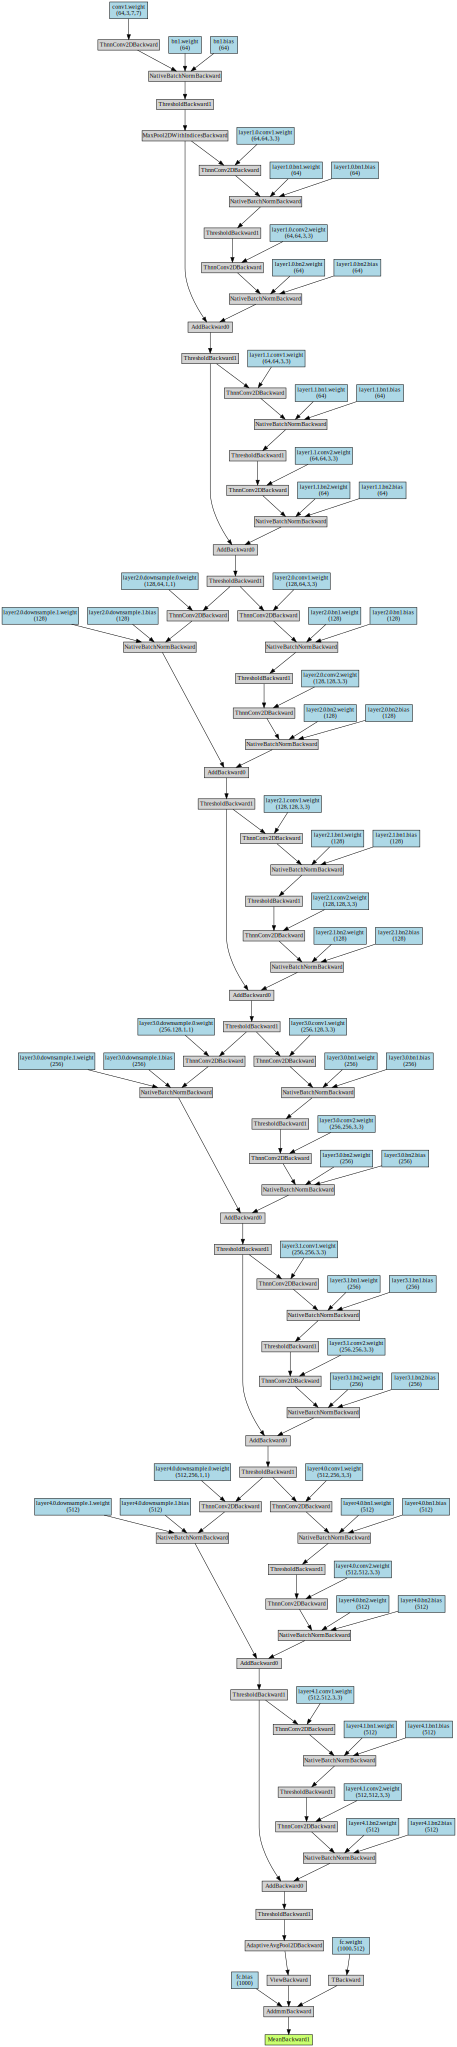

In [59]:
import torchviz
import os
os.environ["PATH"] += os.pathsep + 'D:/graphviz-2.38/release/bin'
model = torchvision.models.resnet18(pretrained=True)
images = torch.randn(32,3,28,28)
score = model(images)

torchviz.make_dot(score.mean(), params=dict(model.named_parameters()))

# [visdom](https://github.com/facebookresearch/visdom)
    pip install visdom

In [60]:
using_visdom = False
if using_visdom:
    pass

# [Tensorboard X](https://github.com/lanpa/tensorboardX)
    pip install tensorboardX
    tensorboard --logdir runs

In [62]:
# demo.py

import torch
import torchvision.utils as vutils
import numpy as np
import torchvision.models as models
from torchvision import datasets
from tensorboardX import SummaryWriter

resnet18 = models.resnet18(False)
writer = SummaryWriter()
sample_rate = 44100
freqs = [262, 294, 330, 349, 392, 440, 440, 440, 440, 440, 440]

for n_iter in range(100):

    dummy_s1 = torch.rand(1)
    dummy_s2 = torch.rand(1)
    # data grouping by `slash`
    writer.add_scalar('data/scalar1', dummy_s1[0], n_iter)
    writer.add_scalar('data/scalar2', dummy_s2[0], n_iter)

    writer.add_scalars('data/scalar_group', {'xsinx': n_iter * np.sin(n_iter),
                                             'xcosx': n_iter * np.cos(n_iter),
                                             'arctanx': np.arctan(n_iter)}, n_iter)

    dummy_img = torch.rand(32, 3, 64, 64)  # output from network
    if n_iter % 10 == 0:
        x = vutils.make_grid(dummy_img, normalize=True, scale_each=True)
        writer.add_image('Image', x, n_iter)

        dummy_audio = torch.zeros(sample_rate * 2)
        for i in range(x.size(0)):
            # amplitude of sound should in [-1, 1]
            dummy_audio[i] = np.cos(freqs[n_iter // 10] * np.pi * float(i) / float(sample_rate))
        writer.add_audio('myAudio', dummy_audio, n_iter, sample_rate=sample_rate)

        writer.add_text('Text', 'text logged at step:' + str(n_iter), n_iter)

        for name, param in resnet18.named_parameters():
            writer.add_histogram(name, param.clone().cpu().data.numpy(), n_iter)

        # needs tensorboard 0.4RC or later
        writer.add_pr_curve('xoxo', np.random.randint(2, size=100), np.random.rand(100), n_iter)

dataset = datasets.MNIST('mnist', train=False, download=True)
images = dataset.test_data[:100].float()
label = dataset.test_labels[:100]

features = images.view(100, 784)
writer.add_embedding(features, metadata=label, label_img=images.unsqueeze(1))

# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()